<a href="https://colab.research.google.com/github/Titiksha20/Forex-rate-Analysis-using-FokkerPlanck/blob/main/Analysis_of_Forex_using_Statistical_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fokker-Planck Equation in Finance

### Plan

1. We take a data for a determined period of time $\Delta t$.

2. Now this data requires processing. First of all *a probability distribution* $P(\Delta t)$ has to be derived. It has been shown in [Mantegna et al., Nature 376 (1995)] that RX data behaves like a non-Gaussian Levy stable
process in the middle of a probability distribution. (*Refer to the article for detailed instruction on what to do, I highlighted it*)

3. Now we compare this data to a turbulent process using fit as shown in [Ghashghaie et al., Nature 381 (1996)] (*In addition we could try fit with Gaussian and other distributions for Mantegna, I think that would be a powerful addition to our project*)

4. Now we return to the [Friedrich, PRL 84 (2000)]. First we take out data and proof that it is statistically dependant. However we use approximation of a Markovian process woth Kolmogorov criteria.

5. We find the conditional probability distribution function of the data.

6. For that approximation we calculate drift and diffusion coefficients (as shown in Friedrich). Then we compare them numerically. F-P equation in this case:
$$
\frac{d \Delta x(\tau)}{d\tau} = D^{(1)}(\Delta x(\tau), \tau) + \sqrt{D^{(2)}(\Delta x(\tau), \tau)} F(\tau)
$$


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gamma
from scipy.integrate import simps
from scipy.optimize import curve_fit
from scipy.stats import levy_stable, cauchy, norm
from collections import defaultdict

## Part 1. Distribution of FX rates fit

### Experimental data probability distribution

We got a dataset for year 2019 exchange rates USD $\Rightarrow$ Polish Zloty from https://github.com/philipperemy/FX-1-Minute-Data . From this, we take the month of October and import the data, plotting our experimental probability distibution.

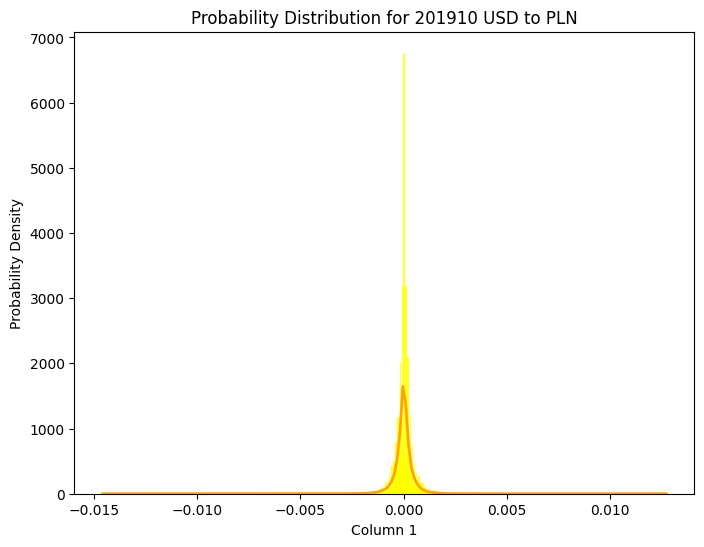

In [ ]:
def experimental_probability_distribution(csv_file, column_index, dt):

    data = pd.read_csv(csv_file, sep=';', header=None)
    filtered_data = data[data.iloc[:, 0].astype(str).str.startswith('201910')]

    column_values = filtered_data.iloc[:, column_index]
    hist_plot_data = np.diff(column_values, n=dt)

    return hist_plot_data

def EPDF_plot(hist_plot_data, column_index):
    plt.figure(figsize=(8, 6))
    _, bins, _ = plt.hist(hist_plot_data, bins='auto', density=True, color="yellow", alpha=0.7, edgecolor="yellow")
    sns.kdeplot(hist_plot_data, color="orange", linewidth=2)

    plt.title(f'Probability Distribution for 201910 USD to PLN')
    plt.xlabel(f'Column {column_index}')
    plt.ylabel('Probability Density')

    row_numbers_for_probabilities = [np.where(np.digitize(hist_plot_data, np.histogram(hist_plot_data, bins=bins, density=True)[1]) == i)[0] for i in range(1, len(bins))]
    row_numbers_for_probabilities = np.array(row_numbers_for_probabilities, dtype=object)
    plt.show()
    return bins, np.histogram(hist_plot_data, bins=bins, density=True)[0], row_numbers_for_probabilities

def EPDF_plot1(hist_plot_data_list, column_index, xlim=None):
    plt.figure(figsize=(8, 6))
    colors = ["m", "green", "blue", "k", "r", "y", "c", "purple", "lime", "olive", "gold", "teal", "navy"]

    for i, hist_plot_data in enumerate(hist_plot_data_list):
        scaling_factor = 1
        shifted_data = hist_plot_data * scaling_factor
        sns.kdeplot(shifted_data, color=colors[i], linewidth=2, label=f"dt={i+1}")

    plt.title(f'Probability Distribution for 201910 USD to PLN shifted')
    plt.xlabel(f'Column {column_index}')
    plt.ylabel('Probability Density')
    #plt.yscale("symlog")
    plt.legend()
    plt.ylim(0, 1700)
    if xlim is not None:
        plt.xlim(xlim)

    plt.show()
    return None

csv_file_path = 'DAT_ASCII_USDPLN_M1_2019.csv'
column_to_plot = 1

# EPDF_plot(experimental_probability_distribution(csv_file_path, column_to_plot), column_to_plot)

bins, probabilities, dts = EPDF_plot(experimental_probability_distribution(csv_file_path, column_to_plot, 1), column_to_plot)
bins = bins[:-1]

Now we plot the same thing in log scale for comfort.

In [ ]:
non_empty_indices = [i for i, arr in enumerate(dts) if len(arr) > 0]
dts = dts[non_empty_indices]
bins = bins[non_empty_indices]
probabilities = probabilities[non_empty_indices]

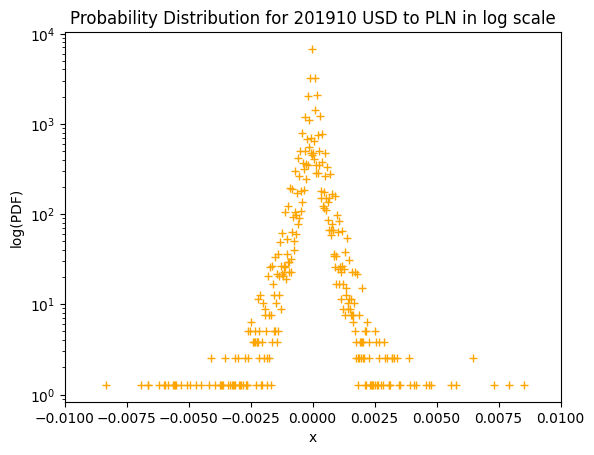

In [ ]:
plt.plot(bins, probabilities, marker = '+', linestyle='None', color="orange")
plt.title(f'Probability Distribution for 201910 USD to PLN in log scale')
plt.yscale("log")
plt.xlabel('x')
plt.ylabel('log(PDF)')
plt.xlim(-0.01, 0.01)
plt.show()

### Levy stable process

Lévy stable process is a stochastic process characterized by both stationary and independant increments.

As a stable distribution, Lévy problems are characterized by four parameters:
1. stability index $\alpha \in (0, 2]$ -- this one describes the behaviour of the distribution near the tails of the function;
2. skewness parameter $\beta \in [-1, 1]$ -- shows how equilibrates the tails of my function are;
3. scale parameter $\sigma > 0$
4. shift parameter $\mu \in \mathcal{R}$

Depending on values of those parameters, the resulting probability distribution can become Gaussian, Cochy, or simply Lévy.

The main significance of this part is to analize those distribution parameters, plot some of the distributions, and familiarize with them.

In general case probability distribution of Levy stable process can be expressed as the integral:
$$
\Phi_{X}(w) = \begin{cases}
\exp{(-\sigma^{\alpha}|w|^{\alpha}(1- i\beta (sign(w))\tan{\frac{\pi\alpha}{2}})+ i\mu w )}\\
\exp{(-\sigma|w|(1+ i\beta \frac{2}{\pi}(sign(w))\ln{|w|})+ i\mu w )}
\end{cases}
$$

### Fit our data

### Fit for our data

Now that we figured out our distributions, it's time to actually calculate the parameters $\alpha$, $\beta$, $\sigma$, and $\mu$ for our data distribution.

In [ ]:
def levy_stable_pdf(x, mu, sigma):
    return levy_stable.pdf(x, 1/2, 0, loc=mu, scale=sigma)

def gaussian_pdf(x, mean, std_dev):
    return norm.pdf(x, loc=mean, scale=std_dev)

def cauchy_pdf(x, location, scale):
    return cauchy.pdf(x, loc=location, scale=scale)

in_val = [np.mean(probabilities), np.std(probabilities)]

initial_guess_levy = in_val
initial_guess_gaussian = in_val
initial_guess_cauchy = in_val

params_levy, _ = curve_fit(levy_stable_pdf, bins, probabilities, p0=initial_guess_levy)
params_gaussian, _ = curve_fit(gaussian_pdf, bins, probabilities, p0=initial_guess_gaussian)
params_cauchy, _ = curve_fit(cauchy_pdf, bins, probabilities, p0=initial_guess_cauchy)

fitted_curve_levy = levy_stable_pdf(np.linspace(-0.005, 0.005, 1000), *params_levy)
fitted_curve_gaussian = gaussian_pdf(np.linspace(-0.005, 0.005, 1000), *params_gaussian)
fitted_curve_cauchy = cauchy_pdf(np.linspace(-0.0005, 0.0005, 1000), *params_cauchy)

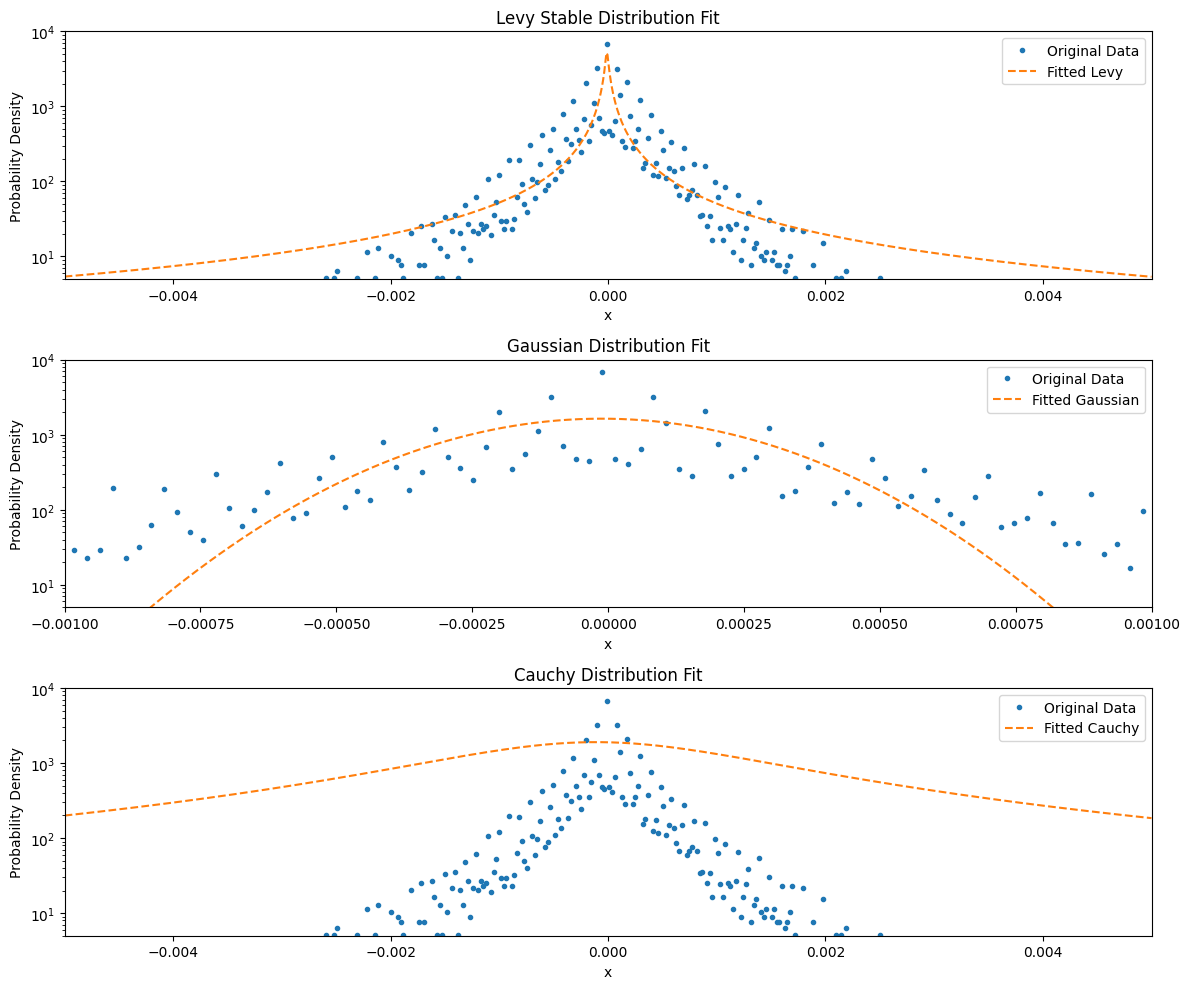

In [ ]:
# Plot the original data and the fitted curves
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.semilogy(bins, probabilities,linestyle = 'none', marker = '.', label='Original Data')
plt.semilogy(np.linspace(-0.005, 0.005, 1000), fitted_curve_levy, label=f'Fitted Levy', linestyle='--')
plt.title('Levy Stable Distribution Fit')
plt.xlabel('x')
plt.xlim(-0.005, 0.005)
plt.ylim(5, 10000)
plt.ylabel('Probability Density')
plt.legend()

plt.subplot(3, 1, 2)
plt.semilogy(bins, probabilities, linestyle = 'none', marker = '.', label='Original Data')
plt.semilogy(np.linspace(-0.005, 0.005, 1000), fitted_curve_gaussian, label=f'Fitted Gaussian', linestyle='--')
plt.title('Gaussian Distribution Fit')
plt.xlabel('x')
plt.xlim(-0.001, 0.001)
plt.ylim(5, 10000)
plt.ylabel('Probability Density')
plt.legend()

plt.subplot(3, 1, 3)
plt.semilogy(bins, probabilities,linestyle = 'none', marker = '.', label='Original Data')
plt.semilogy(np.linspace(-0.005, 0.005, 1000), fitted_curve_cauchy, label=f'Fitted Cauchy', linestyle='--')
plt.title('Cauchy Distribution Fit')
plt.xlabel('x')
plt.xlim(-0.005, 0.005)
plt.ylim(5, 10000)
plt.ylabel('Probability Density')
plt.legend()



plt.tight_layout()
plt.show()

### Turbulent cascades

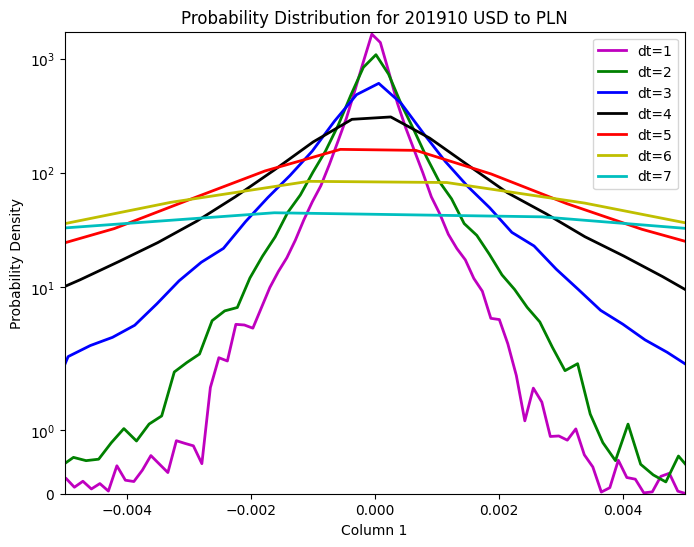

In [ ]:
def EPDF_plot2(hist_plot_data_list, column_index, xlim=None): #ylim=None):
    plt.figure(figsize=(8, 6))
    colors = ["m", "green", "blue", "k", "r", "y", "c", "purple", "lime", "olive", "gold", "teal", "navy"]  # Colors for the plots
    lift_constant = 5

    for i, hist_plot_data in enumerate(hist_plot_data_list):
        #lifted_values = hist_plot_data * i * lift_constant
        sns.kdeplot(hist_plot_data, color=colors[i], linewidth=2, label=f"dt={i+1}")

    plt.title(f'Probability Distribution for 201910 USD to PLN')
    plt.xlabel(f'Column {column_index}')
    plt.ylabel('Probability Density')
    plt.yscale("symlog")
    plt.legend()
    #plt.ylim(10, 10000)
    if xlim is not None:
        plt.xlim(xlim)
    #if ylim is not None:
     #   plt.ylim(ylim)

    plt.show()
    return None

max_dt = 7

hist_plot_data_list = [
    experimental_probability_distribution(csv_file_path, column_to_plot, dt)
    for dt in range(1, max_dt + 1)
]
xlim = (-0.4, 0.4)
xlim1 = (-0.005, 0.005)

EPDF_plot2(hist_plot_data_list, column_to_plot, xlim1)


## Part 2. Fokker-Planck equation + stockastic processes

### Joint probability distribution functions

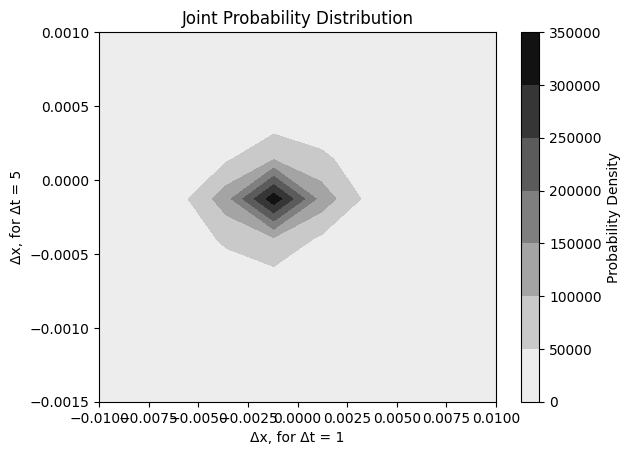

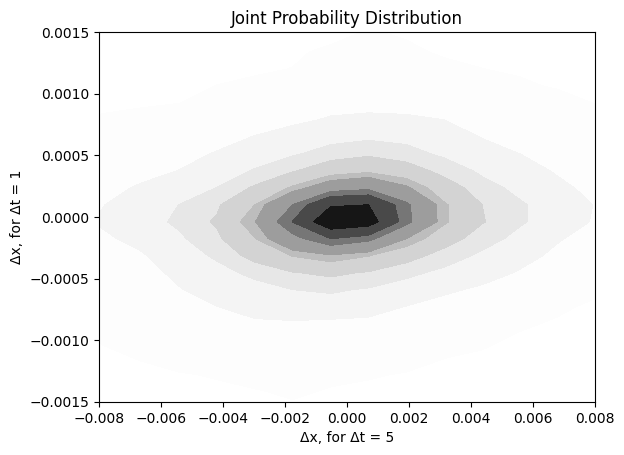

In [ ]:
data1 = experimental_probability_distribution(csv_file_path, column_to_plot, 5)
data2 = experimental_probability_distribution(csv_file_path, column_to_plot, 1)

hist, x_edges, y_edges = np.histogram2d(data1, data2[:len(data1)], bins=(100, 100), density=True)
x, y = np.meshgrid(x_edges[:-1], y_edges[:-1])
plt.contourf(x, y, hist.T, cmap='binary')
plt.xlabel('Δx, for Δt = 1')
plt.ylabel('Δx, for Δt = 5')
plt.xlim(-0.01, 0.01)
plt.ylim(-0.0015, 0.001)
plt.title('Joint Probability Distribution')
plt.colorbar(label='Probability Density')
plt.show()

data = {'Data Array 1': data1, 'Data Array 2': data2[:len(data1)]}
df = pd.DataFrame(data)

sns.kdeplot(data=df, x='Data Array 1', y='Data Array 2', fill=True, cmap='binary')
plt.xlabel('Δx, for Δt = 5')
plt.ylabel('Δx, for Δt = 1')
plt.ylim(-0.0015, 0.0015)
plt.xlim(-0.008, 0.008)
plt.title('Joint Probability Distribution')
plt.show()


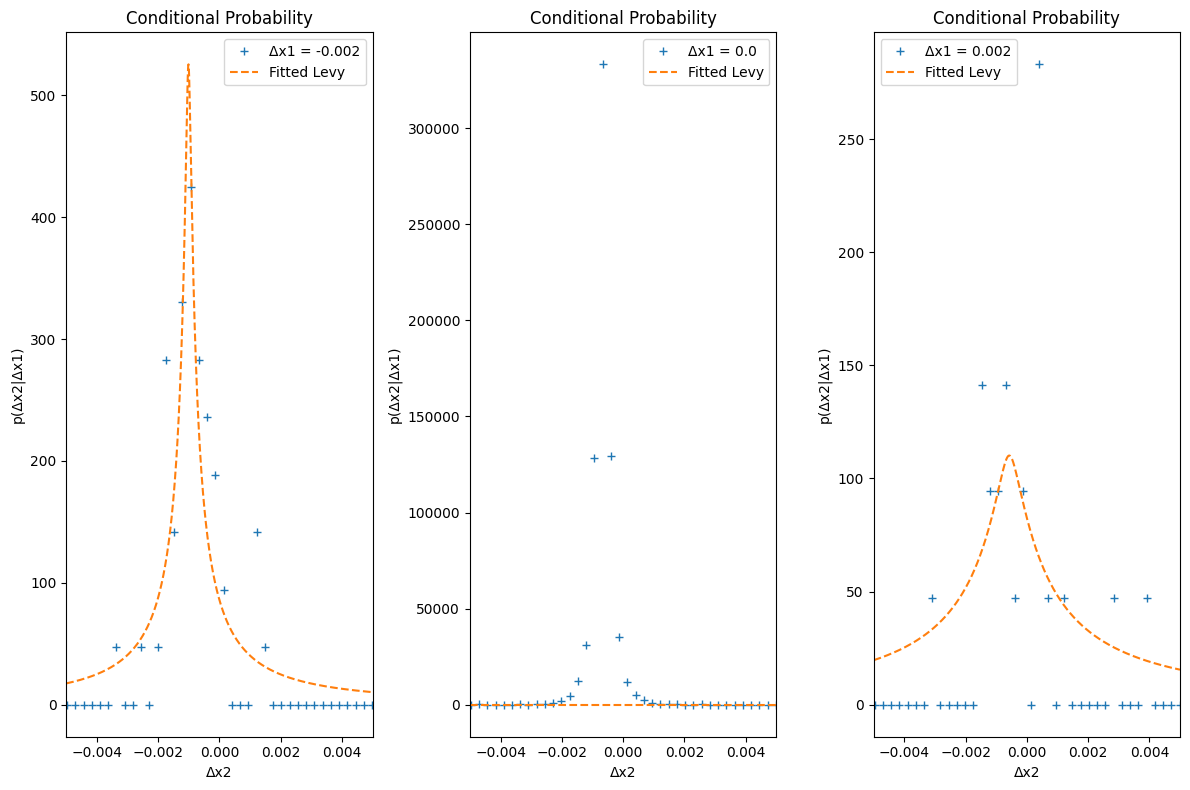

In [ ]:
selected_x_value1 = -0.002
selected_x_value2 = 0.0
selected_x_value3 = 0.002
x_index1 = np.argmin(np.abs(y[:, 0] - selected_x_value1))
x_index2 = np.argmin(np.abs(y[:, 0] - selected_x_value2))
x_index3 = np.argmin(np.abs(y[:, 0] - selected_x_value3))

distribution_values1 = hist.T[x_index1, :]
distribution_values2 = hist.T[x_index2, :]
distribution_values3 = hist.T[x_index3, :]


guess_01 = [np.mean(distribution_values1), np.std(distribution_values1)]
guess_02 = [np.mean(distribution_values2), np.std(distribution_values2)]
guess_03 = [np.mean(distribution_values3), np.std(distribution_values3)]



params_gaussian1, _ = curve_fit(levy_stable_pdf, y[:, 0], distribution_values1, p0=guess_01)
params_gaussian2, _ = curve_fit(levy_stable_pdf, y[:, 0], distribution_values2, p0=guess_02)
params_gaussian3, _ = curve_fit(levy_stable_pdf, y[:, 0], distribution_values3, p0=guess_03)


fitted_curve_gaussian1 = levy_stable_pdf(np.linspace(-0.005, 0.005, 1000), *params_gaussian1)
fitted_curve_gaussian2 = levy_stable_pdf(np.linspace(-0.005, 0.005, 1000), *params_gaussian2)
fitted_curve_gaussian3 = levy_stable_pdf(np.linspace(-0.005, 0.005, 1000), *params_gaussian3)

plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.plot(y[:, 0], distribution_values1, marker = '+', linestyle = 'none', label=f'Δx1 = {selected_x_value1}')
plt.plot(np.linspace(-0.005, 0.005, 1000), fitted_curve_gaussian1, label=f'Fitted Levy', linestyle='--')
plt.xlabel('Δx2')
plt.ylabel('p(Δx2|Δx1)')
plt.xlim(-0.004, 0.004)
plt.title(f'Conditional Probability')
plt.legend()
plt.xlim(-0.005, 0.005)
#plt.ylim(5, 10000)

plt.subplot(1, 3, 2)
plt.plot(y[:, 0], distribution_values2, marker = '+', linestyle = 'none', label=f'Δx1 = {selected_x_value2}')
plt.plot(np.linspace(-0.005, 0.005, 1000), fitted_curve_gaussian2, label=f'Fitted Levy', linestyle='--')
plt.xlabel('Δx2')
plt.ylabel('p(Δx2|Δx1)')
plt.title(f'Conditional Probability')
plt.legend()
plt.xlim(-0.005, 0.005)
#plt.ylim(5, 10000)

plt.subplot(1, 3, 3)
plt.plot(y[:, 0], distribution_values3, marker = '+', linestyle = 'none', label=f'Δx1 = {selected_x_value3}')
plt.plot(np.linspace(-0.005, 0.005, 1000), fitted_curve_gaussian3, label=f'Fitted Levy', linestyle='--')
plt.xlabel('Δx2')
plt.ylabel('p(Δx2|Δx1)')
plt.xlim(-0.004, 0.004)
plt.title(f'Conditional Probability')
plt.legend()
plt.xlim(-0.005, 0.005)
#plt.ylim(5, 10000)



plt.tight_layout()
plt.show()

### Stochastic Processes and Fokker Planck Equation

1) We first determine the Chanpman Kolmogorov Equation:


$$
p(\Delta x_{2},\Delta t_{2}\mid\Delta x_{1},\Delta t_{1})=\int\,d(\Delta x_{i})p(\Delta x_{2},\Delta t_{2}\mid\Delta x_{i},\Delta t_{i})p(\Delta x_{i},\Delta t_{i}\mid\Delta x_{1},\Delta t_{1})
$$

2) After that, we determine the Conditional Probability from the data:

$$
p(\Delta x_{i+1},\Delta t_{i+1}\mid\Delta x_{i},\Delta t_{i})= p(\Delta x_{i+1},\Delta t_{i+1}; \Delta x_{i},\Delta t_{i})/ p(\Delta x_{i},\Delta t_{i}))
$$


3) With the obtained Conditional Probability from the data we determine the Kramers Moyal Coefficient from the below equation and CK condition:


\begin{array}{c}{{D^{(k)}(\Delta x,\tau)=\displaystyle\frac{1}{k!}\,\operatorname*{lim}_{\Delta\tau\rightarrow0}M^{(k)},}}\\ {{}}\\ {{M^{(k)}=\displaystyle\frac{1}{\Delta\tau}\int d\Delta\,x^{\prime}(\Delta x^{\prime},\tau\,+\,\Delta\tau\mid\Delta x,\tau)\,.}}\end{array}

4) After that, we pesent the Ornstein--Uhlenbeck equation, a version of fokker planck equation given below to model and reconstruct:

$$
\frac {d \Delta x^{\prime}}{d \tau} \equiv D^{(1)}(\Delta x(\tau), \tau)+ \sqrt{D^{(2)}(\Delta x(\tau), \tau)} f(\tau)
$$

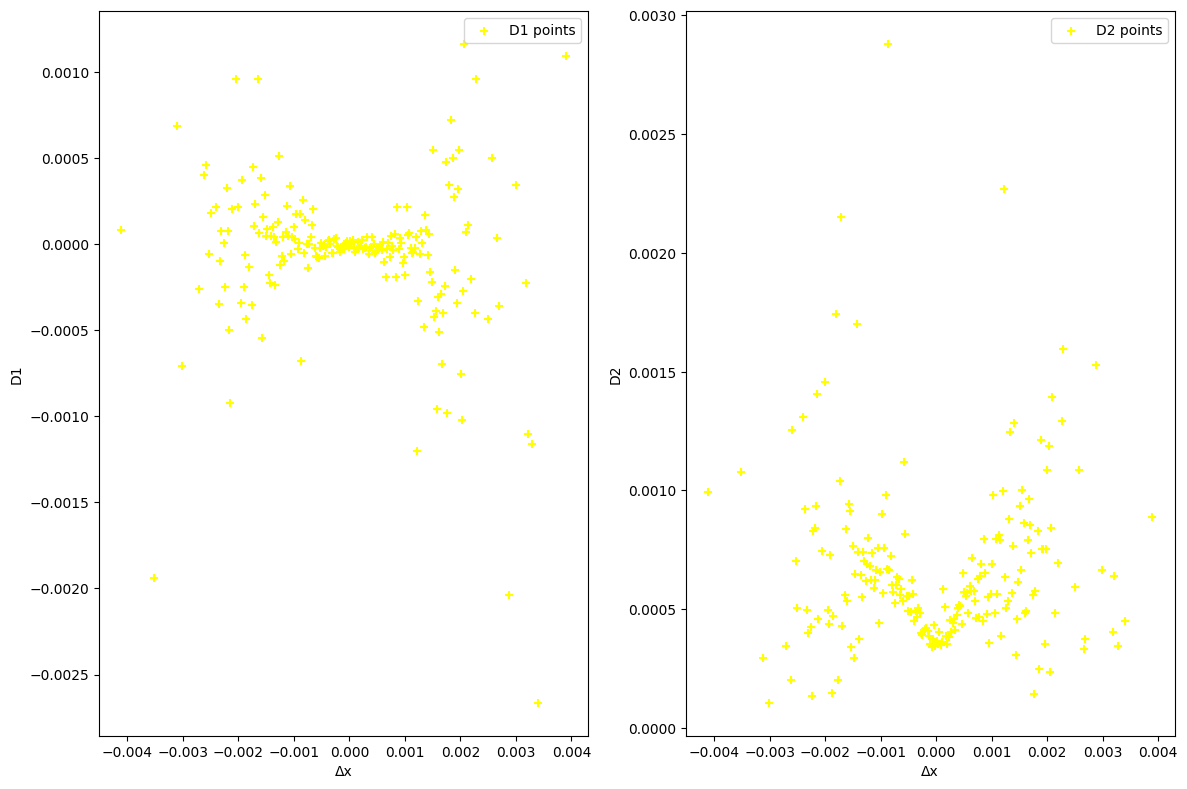

In [ ]:
def cond_probs(rindices, probabilities, bins, dt = 1):
    flat_rindices = np.concatenate(rindices)
    repeat_prob = np.repeat(probabilities, [len(arr) for arr in rindices])
    repeat_bins = np.repeat(bins, [len(arr) for arr in rindices])
    last_step = len(flat_rindices)  # Last time step
    cdf_list = []

    for indices in rindices:
        next_timesteps = [x + dt for x in indices if x + dt < last_step]
        indices_in_flat_rindices = np.where(np.isin(flat_rindices, next_timesteps))[0]
        corresponding_values_in_bins = repeat_bins[indices_in_flat_rindices]
        cdf_list.append(corresponding_values_in_bins)

    return np.array(cdf_list,dtype=object)

cdfs = cond_probs(dts, probabilities, bins)

mean_values = np.array([np.mean(arr) for arr in cdfs])
std_dev_values = np.array([np.std(arr) for arr in cdfs])

non_zero_mask = std_dev_values != 0

mean_values = mean_values[non_zero_mask]
std_dev_values = std_dev_values[non_zero_mask]
bins1 = bins[non_zero_mask]

line_params = np.polyfit(bins1, mean_values, deg=1)
line_fit = np.poly1d(line_params)

quad_params = np.polyfit(bins1, std_dev_values, deg=2)
quad_fit = np.poly1d(quad_params)


plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.scatter(bins1, mean_values, marker = '+', color= 'yellow',label='D1 points')
#plt.plot(bins1, line_fit(bins1), color = 'orange', label=f'D1 Fit: {line_params[0]:.2f}x + {line_params[1]:.2f}')
plt.xlabel('Δx')
plt.ylabel('D1')
#plt.title(f'Conditional Probability')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(bins1, std_dev_values,marker = '+', color= 'yellow', label='D2 points')
#plt.plot(bins1, quad_fit(bins1),color = 'orange', label=f'D2 Fit: {quad_params[0]:.2f}x^2 + {quad_params[1]:.2f}x + {quad_params[2]:.2f}')
plt.xlabel('Δx')
plt.ylabel('D2')
#plt.title(f'Conditional Probability')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
rng = []
for i in range(len(bins1)):
    if -0.0015 <= bins1[i] <= 0.0015:
        rng.append(i)
D2bin = bins1[rng]
D2std = std_dev_values[rng]

In [ ]:
from scipy import stats

def remove_outliers_zscore(data,bins, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    outliers = np.where(z_scores > threshold)[0]
    cleaned_data = np.delete(data, outliers)
    cleaned_bins = np.delete(bins, outliers)
    return cleaned_data, cleaned_bins

In [ ]:
fstd, fbins = remove_outliers_zscore(D2std,D2bin, threshold=3)
q_ = np.polyfit(fbins, fstd, deg=2)
q__ = np.poly1d(q_)
lm, lbin = remove_outliers_zscore(mean_values,bins1, threshold=3)
lpms = np.polyfit(lbin, lm, deg=1)
lf= np.poly1d(lpms)

Text(0, 0.5, 'D1')

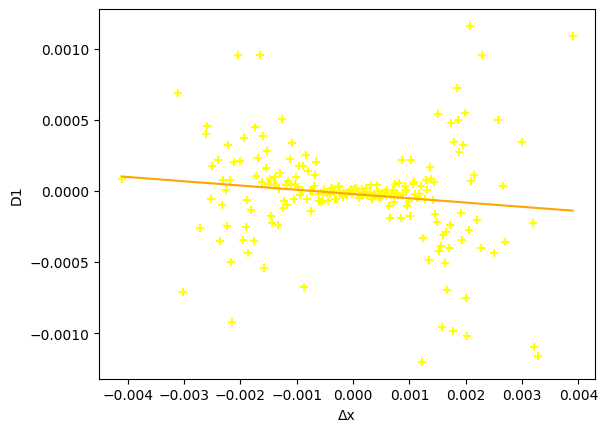

In [ ]:
plt.scatter(lbin, lm, marker = '+', color= 'yellow',label='D1 points')
plt.plot(lbin, lf(lbin), color = 'orange', label=f'D1 Fit: {line_params[0]:.2f}x + {line_params[1]:.2f}')
plt.xlabel('Δx')
plt.ylabel('D1')

In [ ]:
print(f"D1 = : {lpms[0]:.6f}x + {lpms[1]:.6f}")

D1 = : -0.029977x + -0.000021


Text(0, 0.5, 'D2')

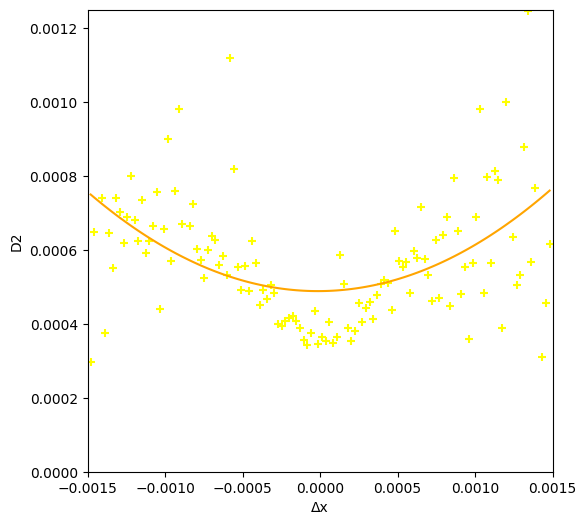

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(fbins, fstd,marker = '+', color= 'yellow', label='D2 points')
plt.plot(fbins, q__(fbins),color = 'orange', label=f'D2 Fit: {quad_params[0]:.2f}x^2 + {quad_params[1]:.2f}x + {quad_params[2]:.2f}')
plt.xlabel('Δx')
plt.xlim(-0.0015, 0.0015)
plt.ylim(0, 0.00125)
plt.ylabel('D2')

In [ ]:
print(f"D2 = : {q__[0]:.6f}x^2 + {q__[1]:.6f}x + {q__[2]:.6f}")

D2 = : 0.000489x^2 + 0.003398x + 121.648876


In [ ]:
from sklearn.metrics import r2_score

# Calculate R2 score
r2c = r2_score(fstd, q__(fbins))

# Print the R2 score
print(f'R2 Score for D2: {r2c}')

R2 Score for D2: 0.19757018508911062


In [ ]:
# Calculate R2 score
r2l = r2_score(lm, lf(lbin))

# Print the R2 score
print(f'R2 Score for D1: {r2l}')

R2 Score for D1: 0.017390780165076225


In [ ]:
from scipy.interpolate import make_interp_spline

In [ ]:
data = pd.read_csv("DAT_ASCII_USDPLN_M1_2019.csv", sep=';', header=None,usecols=range(0, 5))
data.columns = ["DateTime", "Open Bid", "High Bid", "Low Bid", "Close Bid"]

# Display the DataFrame
print(data.head(15))

           DateTime  Open Bid  High Bid  Low Bid  Close Bid
0   20190101 170000   3.73839   3.73908  3.73488    3.73908
1   20190101 170100   3.73898   3.73898  3.73898    3.73898
2   20190101 170200   3.73898   3.73908  3.73888    3.73908
3   20190101 170300   3.73928   3.73939  3.73928    3.73939
4   20190101 170400   3.73928   3.73928  3.73928    3.73928
5   20190101 170500   3.73929   3.74397  3.73929    3.73979
6   20190101 170600   3.73980   3.73980  3.73638    3.73658
7   20190101 170700   3.73668   3.73669  3.73493    3.73493
8   20190101 170900   3.73494   3.73494  3.73494    3.73494
9   20190101 171000   3.73493   3.73984  3.73493    3.73976
10  20190101 171100   3.73977   3.73977  3.73976    3.73976
11  20190101 171200   3.73977   3.73977  3.73493    3.73493
12  20190101 171300   3.73494   3.73494  3.73493    3.73493
13  20190101 171500   3.73494   3.73494  3.73493    3.73493
14  20190101 171600   3.73494   3.73494  3.73493    3.73493


In [ ]:
arr = np.array(data['High Bid'])
arr
x = np.array([i for i in range(len(arr))])
X_Y_Spline = make_interp_spline(x,arr)
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

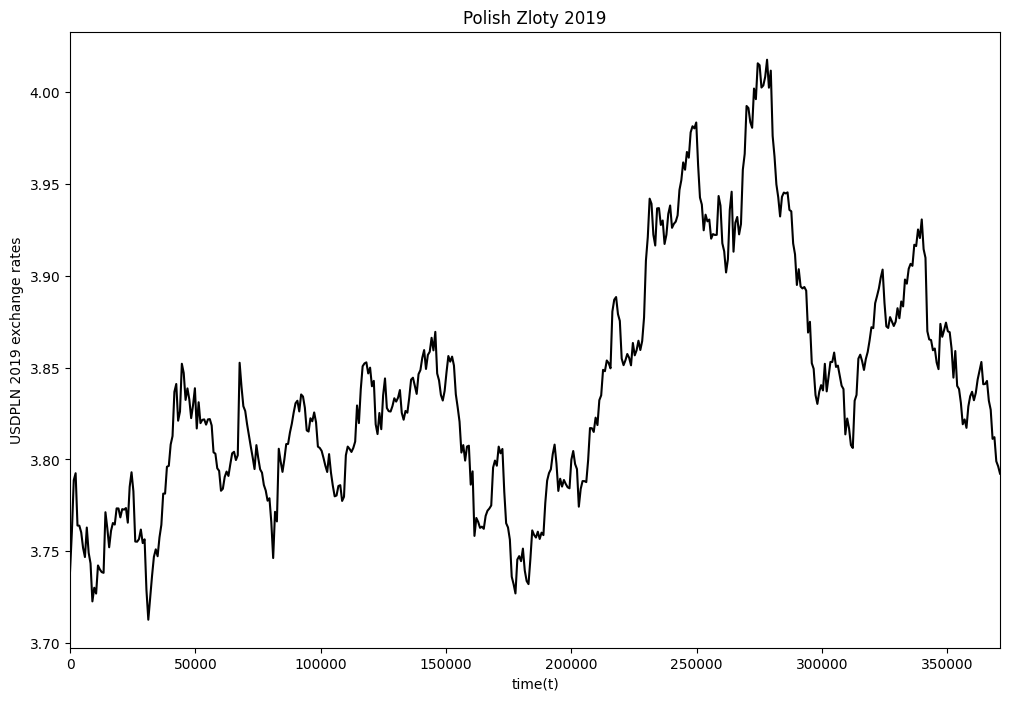

In [ ]:
plt.figure(figsize=(12, 8))
#plt.plot(arr)
plt.plot(X_, Y_,color ='black')
plt.xlabel('time(t)')
plt.ylabel('USDPLN 2019 exchange rates')

plt.xlim(0, 371080)
#plt.ylim(0, 0.00125)
plt.title(f'Polish Zloty 2019')
plt.show()
